# 17. Решения уравнения фильтрации для постоянного дебита

Материалы курсов "Исследования скважин и пластов" и "Гидродинамические исследования скважин" в РГУ нефти и газа имени И.М.Губкина.

Хабибуллин Ринат 2021 г.

версия 0.2 от 14.10.2022

---

In [1]:
# импортируем библиотки, которые могут пригодиться для проведения расчетов
import numpy as np
import matplotlib.pyplot as plt

from anaflow import get_lap_inv
from scipy.special import kn, iv, expi

%matplotlib inline

Рассматривается уравнение фильтрации в безразмерных переменных 

$$ 
\frac{\partial p_D}{ \partial t_D} = \frac{1}{r_D}\left[ \frac{ \partial{}}{ \partial{r_D} }\left( r_D \dfrac{\partial p_D}{ \partial r_D} \right) \right]  
\tag{17.1}
$$

где введены следующие безразмерные переменные
* $r_D$ - безразмерное расстояние от центра скважины
* $t_D$ - безразмерное время
* $p_D$ - безразмерное давление

Соответствующие определения безразмерных переменных

$$ r_D = \frac{r}{r_w} \tag{17.2}$$
$$ t_D = \frac{0.00036 kt}{\phi \mu c_t r_w^2}  \tag{17.3}$$
$$ p_D = \frac{kh}{ 18.41 q_s B \mu} \left( p_i - p \right)  \tag{17.4} $$

где в свою очередь 
* $q_s$ - дебит скважины на поверхности, приведенный к нормальным условиям, м3/сут
* $\phi$ - пористость, доли единиц
* $\mu$ - вязкость нефти в пласте, сП
* $B$ - объемный коэффициент нефти, м3/м3
* $p_i$ - начальное давление в пласте, атм
* $p$ - давление забойное, атм
* $c_t$ - общая сжимаемость системы в пласте, 1/атм
* $k$ - проницаемость, мД
* $t$ -  время, час
* $r$ - расстояние от центра скважины, м
* $r_w$ - радиус скважины, м

In [2]:
# определим функции для перевода размерных переменных в безразмерные и обратно
# пригодится потом для построения графиков и ведения расчетов

# при наименовании функций придерживаемся следующих соглашений
# сначала идет название того, что считаем
# в конце указывается размерность результата, если это уместно

def r_from_rd_m(rd, rw_m=0.1):
    """
    перевод безразмерного расстояния в размерное
    rd -  безразмерное расстояние
    rw_m -  радиус скважины, м
    """
    return rd*rw_m

def rd_from_r(r_m, rw_m=0.1):
    """
    перевод размерного расстояния в безразмерное
    r_m - размерное расстояние, м
    rw_m - радиус скважины, м
    """
    return r_m/rw_m

def t_from_td_hr(td, k_mD=10, phi=0.2, mu_cP=1, ct_1atm=1e-5, rw_m=0.1):
    """
    перевод безразмерного времени в размерное, результат в часах
    td - безразмерное время
    k_mD - проницаемость пласта, мД
    phi - пористость, доли единиц
    mu_cP - динамическая вязкость флюида, сП
    ct_1atm - общая сжимаемость, 1/атм
    rw_m - радиус скважины, м
    """
    return td * phi * mu_cP * ct_1atm * rw_m * rw_m / k_mD / 0.00036

def td_from_t(t_hr, k_mD=10, phi=0.2, mu_cP=1, ct_1atm=1e-5, rw_m=0.1):
    """
    перевод размерного времени в безразмерное
    t_hr - размерное время, час
    k_mD - проницаемость пласта, мД
    phi - пористость, доли единиц
    mu_cP - динамическая вязкость флюида, сП
    ct_1atm - общая сжимаемость, 1/атм
    rw_m - радиус скважины, м
    """
    return  0.00036 * t_hr * k_mD / (phi * mu_cP * ct_1atm * rw_m * rw_m) 

def p_from_pd_atma(pd, k_mD=10, h_m=10, q_sm3day=20, b_m3m3=1.2, mu_cP=1, pi_atma=250):
    """
    перевод безразмерного давления в размерное, результат в абсолютных атмосферах
    pd - безразмерное давление
    k_mD - проницаемость пласта, мД
    h_m - мощность пласта, м
    q_sm3day - дебит на поверхности, м3/сут в с.у.
    b_m3m3 - объемный коэффициент нефти, м3/м3
    mu_cP - динамическая вязкость флюида, сП
    pi_atma - начальное давление, абсолютные атм.
    """
    return pi_atma - pd * 18.41 * q_sm3day * b_m3m3 * mu_cP / k_mD / h_m 

def pd_from_p(p_atma, k_mD=10, h_m=10, q_sm3day=20, b_m3m3=1.2, mu_cP=1, pi_atma=250):
    """
    перевод размерного давления в безразмерное
    p_atma - давление
    k_mD - проницаемость пласта, мД
    h_m - мощность пласта, м
    q_sm3day - дебит на поверхности, м3/сут в с.у.
    b_m3m3 - объемный коэффициент нефти, м3/м3
    mu_cP - динамическая вязкость флюида, сП
    pi_atma - начальное давление, абсолютные атм.
    """
    return (pi_atma - p_atma) / (18.41 * q_sm3day * b_m3m3 * mu_cP) * k_mD * h_m 


Введем безразмерный дебит следующим образом 

$$ q_D = \frac{18.41 B \mu }{kh \left( p_i - p \right)}  q_s \tag{17.5} $$


Тогда выражение для получение размерного дебита из безразмерного примет вид
$$ q_s = \frac{kh}{ 18.41 B \mu} \left( p_i - p \right) q_D \tag{17.6} $$



In [3]:

def q_from_qd_sm3day(qd, k_mD=10, h_m=10, b_m3m3=1.2, mu_cP=1, dp_atm=50):
    """
    перевод безразмерного дебита скважины в размерный
    qd - безразмерный дебит скважины
    k_mD - проницаемость пласта, мД
    h_m - мощность пласта, м
    b_m3m3 - объемный коэффициент нефти, м3/м3
    mu_cP - динамическая вязкость флюида, сП
    dp_atm - перепад давлений, атм.
    """
    return dp_atm / (18.41 * b_m3m3 * mu_cP) * k_mD * h_m * qd

def qd_from_q(q_sm3day, k_mD=10, h_m=10, b_m3m3=1.2, mu_cP=1, dp_atm=50):
    """
    перевод размерного дебита в безразмернфе
    q_sm3day -  дебит скважины, ст. м3/сут
    k_mD - проницаемость пласта, мД
    h_m - мощность пласта, м
    b_m3m3 - объемный коэффициент нефти, м3/м3
    mu_cP - динамическая вязкость флюида, сП
    dp_atm - перепад давлений, атм.
    """
    return 1 / (dp_atm / (18.41 * b_m3m3 * mu_cP) * k_mD * h_m) * q_sm3day

Для введенного безразмерного дебита можно показать, что если известное решение в пространстве Лапласа для задачи с постоянным дебитом $\tilde{p}_D(s)$ тогда решение симметричной задачи с постоянным давлением для безразмерного дебита $\tilde{q}_D(s)$ на скважине можно найти из выражения 

$$ \tilde{p}_D(s) \tilde{q}_D(s) =\frac{1}{s^2} \tag{17.7} $$

Пример 

Решение задачи с постоянным дебитом для конечного радиуса скважины в пространстве Лапласа будет иметь вид


$$ \tilde{p}_D(s) = \frac{1}{s^{\frac{3}{2}}} \frac{ K_0 \left( r_D \sqrt s  \right) }{K_1 \left(  \sqrt s  \right)} \tag{17.8}$$

где 

$K_0$, $K_1$ - <a href="https://ru.wikipedia.org/wiki/%D0%9C%D0%BE%D0%B4%D0%B8%D1%84%D0%B8%D1%86%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5_%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%B8_%D0%91%D0%B5%D1%81%D1%81%D0%B5%D0%BB%D1%8F"
                        target="_blank" rel="noreferrer noopener">модифицированные функции Бесселя&nbsp;</a>
                        
Тогда для случая постоянного забойного давления можно получить

$$ \tilde{q}_D(s) = \frac{1}{s^{\frac{1}{2}}} \frac{ K_1 \left(  \sqrt s  \right) }{K_0 \left(  \sqrt s  \right)} \tag{17.9}$$

К решению для безразмерного дебита также можно применить обратное преобразование Лапласа и получить значения безразмерного дебита и затем и размерного дебита. 

## Примеры расчетов. Построение решения для постоянного дебита

In [4]:
# пример функции реализующий расчет решения в пространстве Лапласа
def pd_lapl_finite_rw(u, rd=1.):
    """
    расчет решения c конечным радиусом скважины для безразмерного давления в пространстве Лапласа
    u - переменная пространства Лапласа
    rd- безразмерное расстояние от центра скважины
    """
    # полезно учесть, что при u>5e5 выражение kn(1, u05) обратится в ноль и будет деление на ноль
    # но если принудительно сделать там выражение равное нулу, обратное преобразование Лапласа
    # может выдавать очень странные результаты, поэтому лучше пока оставить как есть
    u05 = u**0.5
    return np.divide(kn(0, rd * u05) , (u * u05 *  kn(1, u05)))


# функция расчета безразмерного давления с использованием алгоритма Стефеста
# для численного обратного преобразования Лапласа
def pd_finite_rw(td, rd=1.):
    """
    расчет решения c конечным радиусом скважины для безразмерного давления
    на основе численного обратного преобразования Лапласа (алгоритм Стефеста)
    td - безразмерное давление, число или numpy массив
    rd - безразмерный радиус, по умолчанию rd=1 - соответствует давлению на забое
    результат массив массивов давления от времени
    """
    pd_inv = get_lap_inv(pd_lapl_finite_rw, rd=rd)
    return pd_inv(td)

pd_super = np.vectorize(pd_finite_rw)

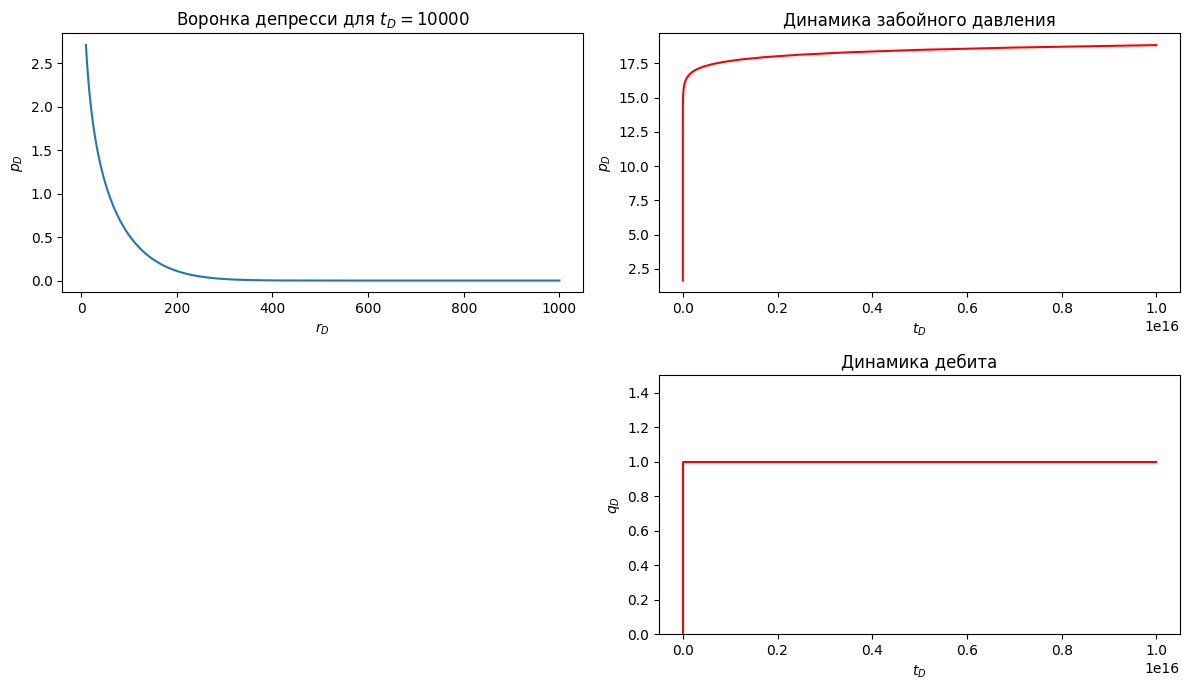

In [5]:
# задаем параметры для отрисовки отдельных графиков
td = 10000
rd = 1
# задаем массивы для отрисовки графиков - количество точек на графике
rd_arr = np.logspace(1, 3, 100)
td_arr = np.logspace(1, 16, 100)

# создаем фигуру с двумя графиками, на котором все будет отрисовываться
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,7), gridspec_kw={'height_ratios': [2, 2]})

# задаем первый график используя оси ax1
ax1.plot(rd_arr, pd_super(td, rd_arr) )
ax1.set(title="Воронка депресси для $t_D= {}$".format(td))
ax1.set_xlabel("$r_D$")
ax1.set_ylabel("$p_D$")

# задаем первый график используя оси ax2
ax2.plot(td_arr, pd_super(td_arr, rd), color = 'red')
ax2.set(title="Динамика забойного давления")
ax2.set_xlabel("$t_D$")
ax2.set_ylabel("$p_D$")

ax3.axis('off')
ax4.plot([0,0,td_arr[-1]],[0, 1, 1], color = 'red')
ax4.set(title="Динамика дебита")
ax4.set_xlabel("$t_D$")
ax4.set_ylabel("$q_D$")
ax4.set_ylim(0, 1.5)

fig.tight_layout()
plt.show()

## Примеры расчетов. Построение решения для постоянного забойного давления

In [6]:
# пример функции реализующий расчет решения в пространстве Лапласа
def qd_lapl_finite_rw(u):
    """
    расчет решения c конечным радиусом скважины для безразмерного давления в пространстве Лапласа
    u - переменная пространства Лапласа
    rd- безразмерное расстояние от центра скважины
    """
    # полезно учесть, что при u>5e5 выражение kn(1, u05) обратится в ноль и будет деление на ноль
    # но если принудительно сделать там выражение равное нулу, обратное преобразование Лапласа
    # может выдавать очень странные результаты, поэтому лучше пока оставить как есть
    u05 = u**0.5
    return np.divide(kn(1, rd * u05) , (u05 *  kn(0, u05)))


# функция расчета безразмерного давления с использованием алгоритма Стефеста
# для численного обратного преобразования Лапласа
def qd_finite_rw(td):
    """
    расчет решения c конечным радиусом скважины для безразмерного давления
    на основе численного обратного преобразования Лапласа (алгоритм Стефеста)
    td - безразмерное давление, число или numpy массив
    rd - безразмерный радиус, по умолчанию rd=1 - соответствует давлению на забое
    результат массив массивов давления от времени
    """
    qd_inv = get_lap_inv(qd_lapl_finite_rw)
    return qd_inv(td)


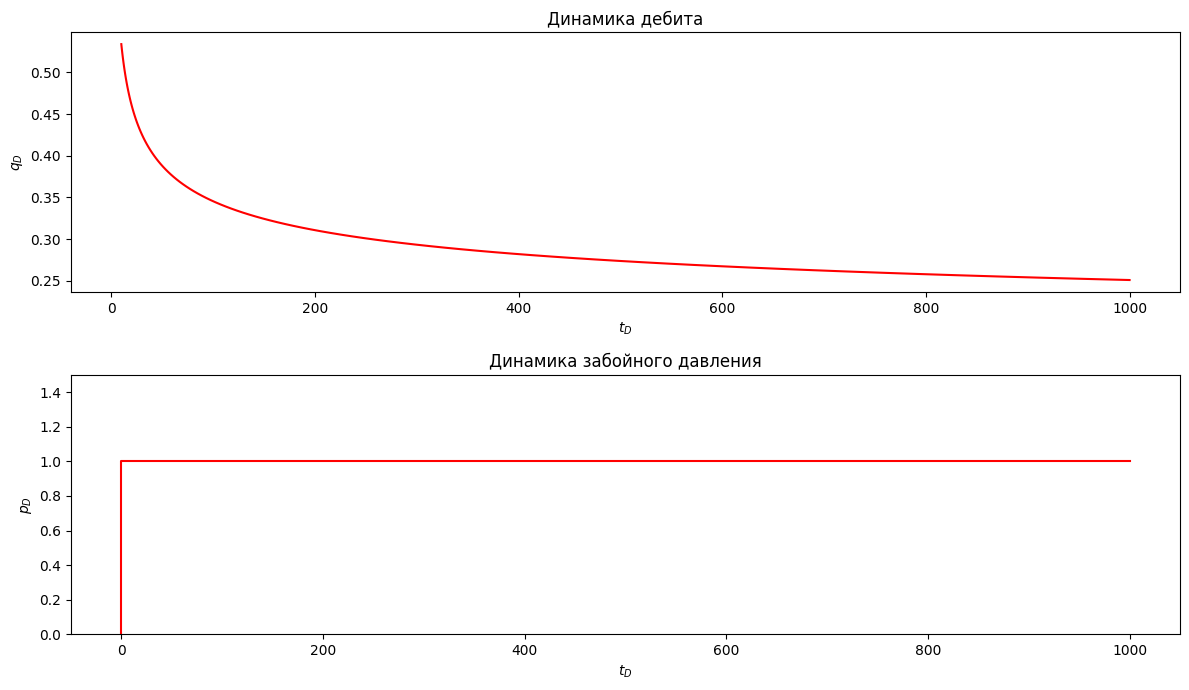

In [7]:
# задаем параметры для отрисовки отдельных графиков
td = 10000
# задаем массивы для отрисовки графиков - количество точек на графике
td_arr = np.logspace(1, 3, 100)

# создаем фигуру с двумя графиками, на котором все будет отрисовываться
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,7), gridspec_kw={'height_ratios': [2, 2]})


# задаем первый график используя оси ax2
ax1.plot(td_arr, qd_finite_rw(td_arr), color = 'red')
ax1.set(title="Динамика дебита")
ax1.set_xlabel("$t_D$")
ax1.set_ylabel("$q_D$")

ax2.plot([0,0,td_arr[-1]],[0, 1, 1], color = 'red')
ax2.set(title="Динамика забойного давления")
ax2.set_xlabel("$t_D$")
ax2.set_ylabel("$p_D$")
ax2.set_ylim(0, 1.5)

fig.tight_layout()
plt.show()

Нарисуем графики в размерных координатах

In [8]:
np.concatenate([[0], t_from_td_hr(td_arr)])

array([0.00000000e+00, 5.55555556e-05, 5.82008752e-05, 6.09721536e-05,
       6.38753886e-05, 6.69168633e-05, 7.01031602e-05, 7.34411749e-05,
       7.69381317e-05, 8.06015988e-05, 8.44395046e-05, 8.84601552e-05,
       9.26722521e-05, 9.70849111e-05, 1.01707682e-04, 1.06550570e-04,
       1.11624056e-04, 1.16939119e-04, 1.22507263e-04, 1.28340539e-04,
       1.34451570e-04, 1.40853583e-04, 1.47560432e-04, 1.54586633e-04,
       1.61947392e-04, 1.69658639e-04, 1.77737063e-04, 1.86200147e-04,
       1.95066207e-04, 2.04354432e-04, 2.14084922e-04, 2.24278737e-04,
       2.34957937e-04, 2.46145637e-04, 2.57866046e-04, 2.70144532e-04,
       2.83007667e-04, 2.96483291e-04, 3.10600566e-04, 3.25390045e-04,
       3.40883737e-04, 3.57115173e-04, 3.74119481e-04, 3.91933462e-04,
       4.10595669e-04, 4.30146490e-04, 4.50628239e-04, 4.72085242e-04,
       4.94563936e-04, 5.18112970e-04, 5.42783310e-04, 5.68628345e-04,
       5.95704012e-04, 6.24068907e-04, 6.53784418e-04, 6.84914855e-04,
      

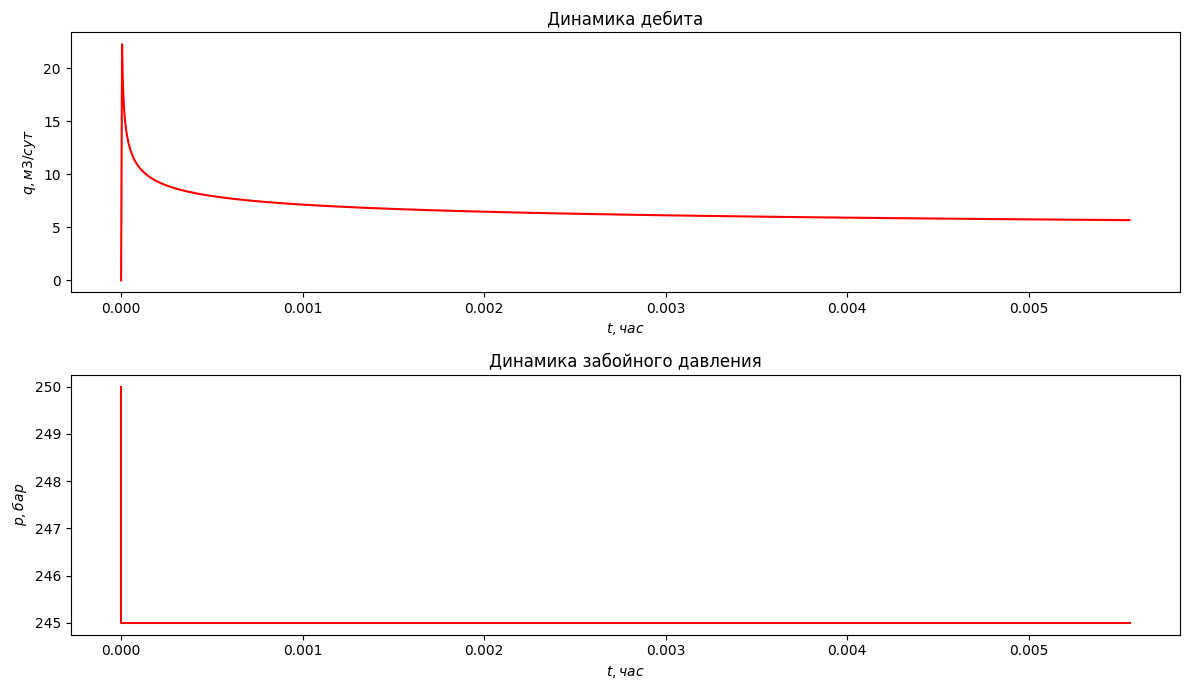

In [9]:
# задаем параметры для отрисовки отдельных графиков
td = 10000
# задаем массивы для отрисовки графиков - количество точек на графике
td_arr = np.logspace(0, 3, 100)
p_i = 250
dp = 5

# создаем фигуру с двумя графиками, на котором все будет отрисовываться
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,7), gridspec_kw={'height_ratios': [2, 2]})


# задаем первый график используя оси ax2
ax1.plot(np.concatenate([[0], t_from_td_hr(td_arr)]), 
         np.concatenate([[0], q_from_qd_sm3day( qd_finite_rw(td_arr), dp_atm = dp )]), 
         color = 'red')
ax1.set(title="Динамика дебита")
ax1.set_xlabel("$t, час$")
ax1.set_ylabel("$q, м3/сут$")

ax2.plot([0,0,t_from_td_hr(td_arr)[-1]], p_i - dp *  np.array([0, 1., 1.] ), color = 'red')
ax2.set(title="Динамика забойного давления")
ax2.set_xlabel("$t, час$")
ax2.set_ylabel("$p, бар$")
#ax2.set_ylim(0, 1.5)

fig.tight_layout()
plt.show()

In [10]:
def q_simple():
    return 1

Для решения с постоянным забойным давлением также работает принцип суперпозиции

# Задание 

1. Постройте решение для скважины работающей последовательно с несколькими разными величинами забойных давлений